# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
# mount google disk
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
data = pd.read_csv('gdrive/My Drive/datasets/train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
data = data.drop("dropoff_datetime", axis=1)
data['pickup_datetime'] =  pd.to_datetime(data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [7]:
x = data["trip_duration"].values

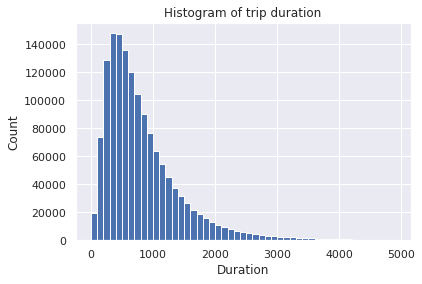

In [8]:
# the histogram of the data
min_duration = x.min()
max_duration = x.max()
n, bins, patches = plt.hist(data["trip_duration"].values, bins=[i for i in range(min_duration, max_duration, 100)][:50])


plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of trip duration')
plt.grid(True)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Можно сказать, что у людей в основном поездки по 5-20 минут, могли бы и пешком пройтись.

Очень похоже, что целевая переменная имеет логнормальное распределение (то есть она = $e^x$, где x -- нормальное). Чтобы в этом убедиться, построим гисторграмму в логарифмической сетке

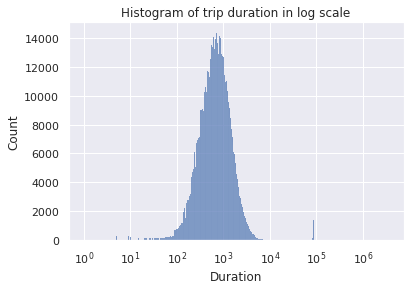

In [9]:
sns.histplot(data=data.trip_duration, log_scale=True)

plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of trip duration in log scale')
plt.show()

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Потому что нам важно предсказать именно порядок продолжительности поездки в секундах, точность до секуднд не очень важна, есть поездки и по 100 сек и по 1000 сек и нам надо понимать именно порядок.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: RMSLE <=> MSLE, так как корень -- монотонная функция и обратимая функция на нашей области значений, значит точка оптимума у нас одна и та же будет. MSLE <=> MSE для $\hat{y}_i$ и $\hat{a}(x_i)$ по тем же причинам: так как $\hat{a}(x_i) = \log{(a(x_i) + 1)}$ и на нашей области определения все эти функции (логарифм + линейный сдвиг) являются монотонными и обратимыми, то точка оптимума будет та же. (Обсуждали это на семинарх бтв), значит RMSLE <=> MSLE <=> MSE для $\hat{y}_i$ и $\hat{a}(x_i)$.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [10]:
data["log_trip_duration"] = np.log1p(data["trip_duration"])

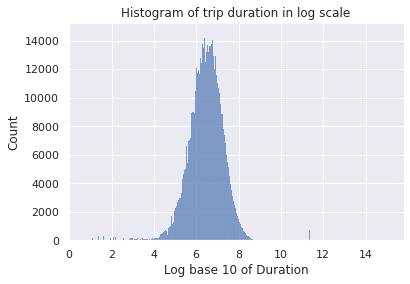

In [11]:
sns.histplot(data=data.log_trip_duration)

plt.xlabel('Log base 10 of Duration')
plt.ylabel('Count')
plt.title('Histogram of trip duration in log scale')
plt.show()

In [12]:
# data.drop("trip_duration", axis=1, inplace=True) <- Не буду дропать, потому что дальше надо будет

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [13]:
from sklearn.metrics import mean_squared_error

best_constant = data.log_trip_duration.mean()
print("RMSE with best constant = %.4f" % mean_squared_error(data.log_trip_duration, best_constant * np.ones(data.log_trip_duration.shape), squared=False
                                                                  ))

RMSE with best constant = 0.7958


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


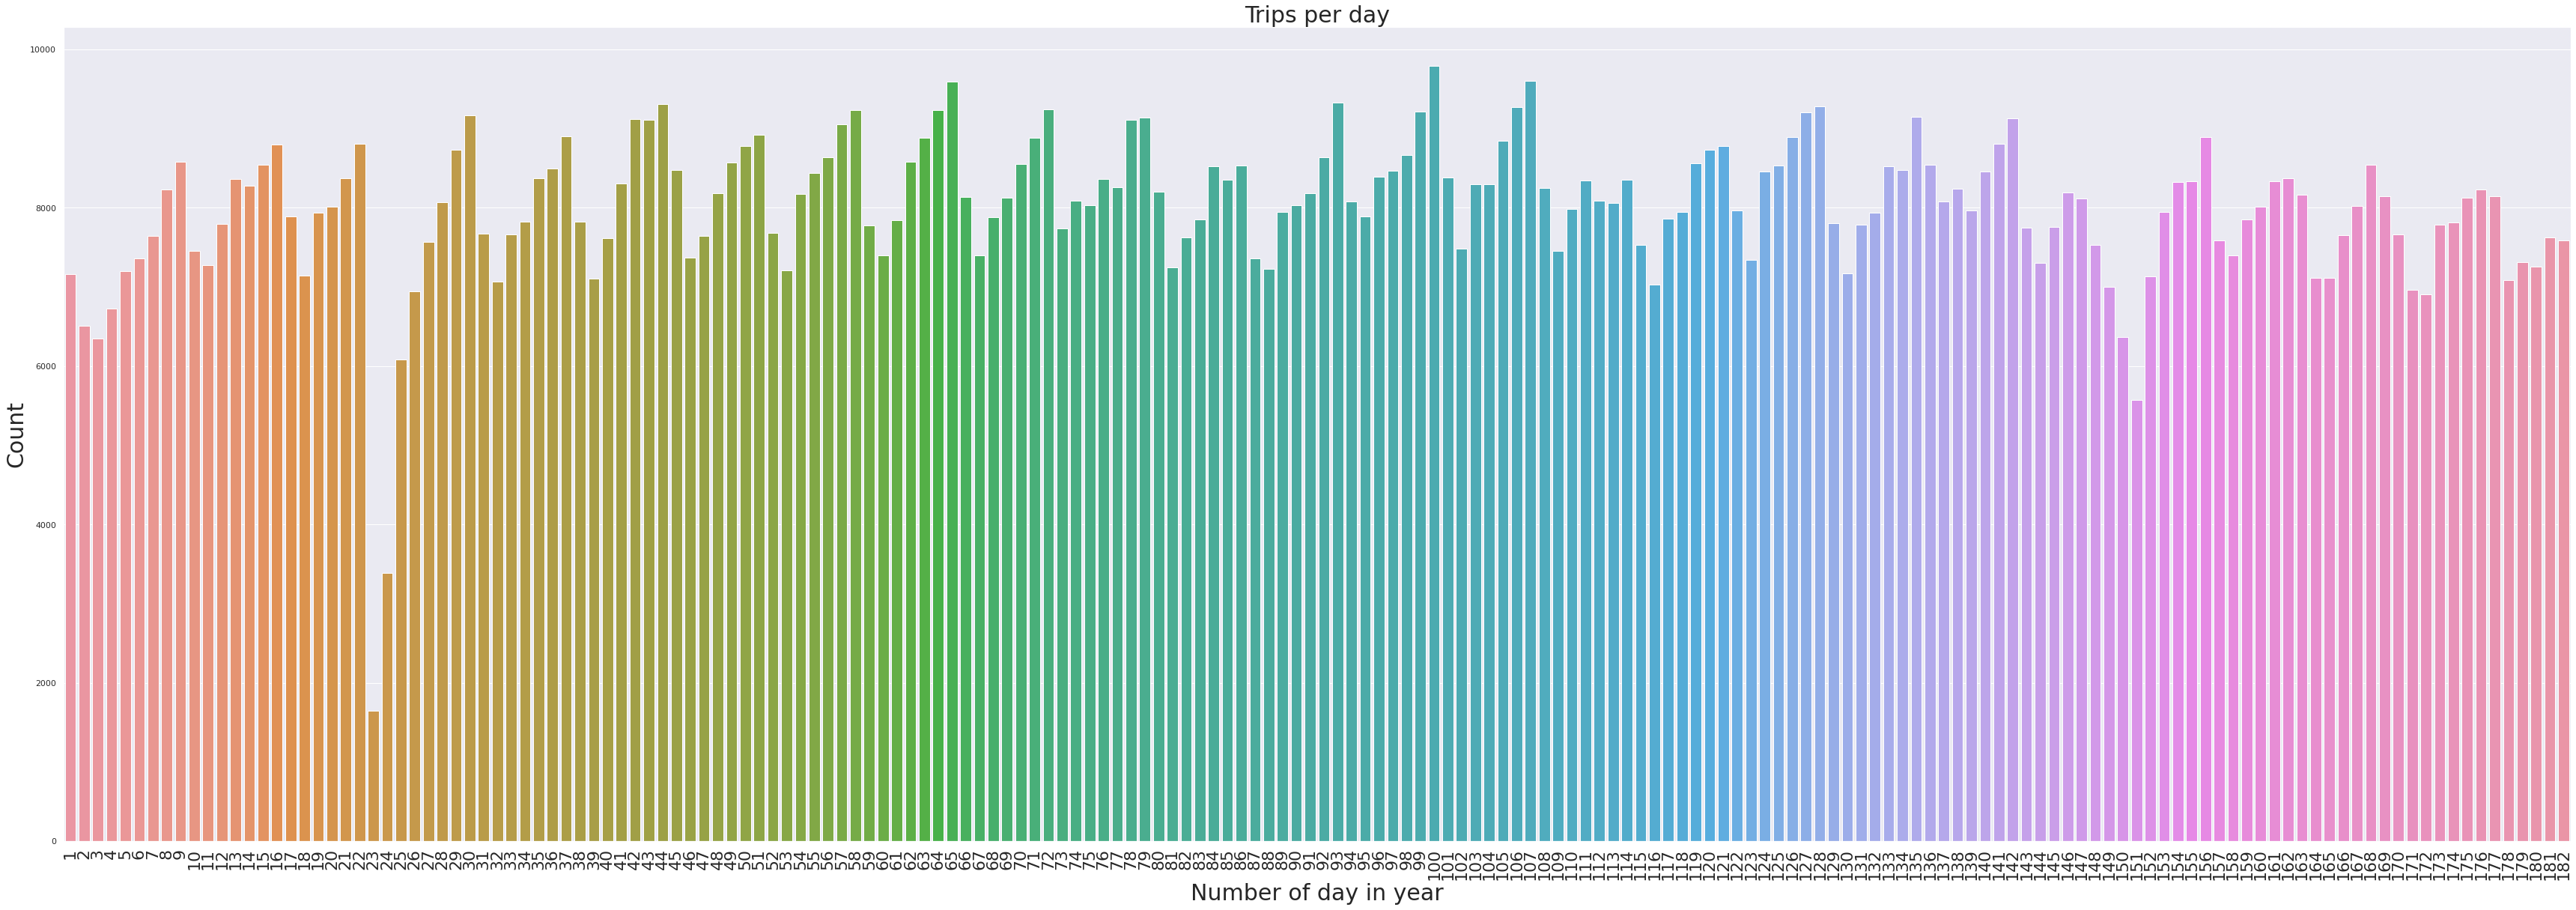

In [14]:
a4_dims = (60, 20)
fig, ax = plt.subplots(figsize=a4_dims)

chart = sns.countplot(data.pickup_datetime.dt.dayofyear, data=data)
plt.draw()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=22)
plt.title("Trips per day", fontsize=30)
plt.xlabel('Number of day in year', fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

23-25 января 2016 года была очень сильная буря в Нью-Йорке и движение перекрыли. 30 мая 2016 (151 день) играли Yankees

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [15]:
by_week_days = data.groupby(data['pickup_datetime'].dt.weekday).count()

In [16]:
by_hours = data.groupby(data['pickup_datetime'].dt.hour).count()

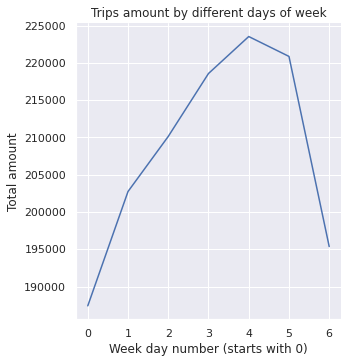

In [17]:
(sns.relplot(x=by_week_days.index, y='id', data=by_week_days, kind='line')
 .set_axis_labels('Week day number (starts with 0)', 'Total amount'))

plt.title("Trips amount by different days of week")
plt.show()

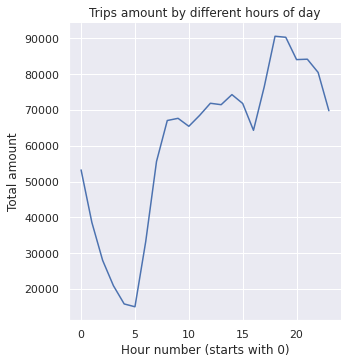

In [18]:
(sns.relplot(x=by_hours.index, y='id', data=by_hours, kind='line')
 .set_axis_labels('Hour number (starts with 0)', 'Total amount'))

plt.title("Trips amount by different hours of day")
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [19]:
by_hour_and_month = pd.DataFrame(data.groupby([(data['pickup_datetime'].dt.hour), (data['pickup_datetime'].dt.month)]).count().id)
by_hour_and_month.index.names = ["hour", "month"]
by_hour_and_month.rename(columns={"id" : "amount"}, inplace=True)


by_hour_and_day = pd.DataFrame(data.groupby([(data['pickup_datetime'].dt.hour), (data['pickup_datetime'].dt.weekday)]).count().id)
by_hour_and_day.index.names = ["hour", "day"]
by_hour_and_day.rename(columns={"id" : "amount"}, inplace=True)

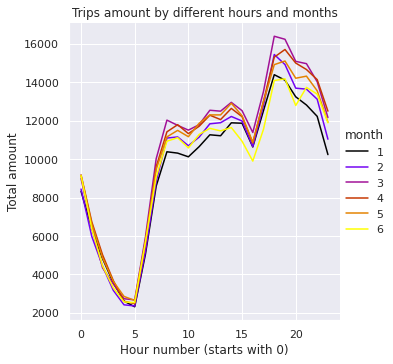

In [20]:
chart = sns.relplot(x=by_hour_and_month.index.get_level_values("hour"),
             y='amount',
             hue=by_hour_and_month.index.get_level_values("month"),
             data=by_hour_and_month,
             kind='line',
             palette="gnuplot")
chart.set_axis_labels('Hour number (starts with 0)', 'Total amount')


plt.title("Trips amount by different hours and months")
plt.show()

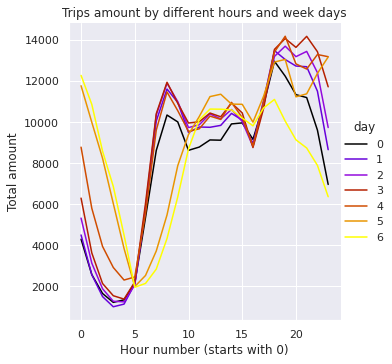

In [21]:
(sns.relplot(x=by_hour_and_day.index.get_level_values("hour"),
             y='amount',
             hue=by_hour_and_day.index.get_level_values("day"),
             data=by_hour_and_day,
             kind='line',
             palette="gnuplot")
 .set_axis_labels('Hour number (starts with 0)', 'Total amount'))

plt.title("Trips amount by different hours and week days")
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Дни недели: по понедельникам в целом ездят меньше всего, по пятницам больше всего, по воскресеньям ездят довольно мало. 

Часы: пик поездок приходится на 18-20 часов (все едут с работы), быстро растет с 5 до 10 часов (едут на работу) и быстро падает с 24 до 5 часов (все ложаться спать).

Разбивка по месяцам и часам: ничего примечательного, все месяцы в этом плане похожи.

Разбивка по дням недели и часам: в выходные (сб, вс) ездят больше с 24 до 5, чем в будние дни (так как тусят). А в будние ездят больше с 5 до 10 часов, так как едут на работу. 

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3)

In [23]:
mean_by_weekday = pd.DataFrame(train.groupby(data['pickup_datetime'].dt.weekday).mean()["log_trip_duration"])
mean_by_weekday.index.names = ["param"]
mean_by_weekday.rename(columns={"log_trip_duration" : "mean_log_trip_duration"}, inplace=True)

mean_by_hour = pd.DataFrame(train.groupby(data['pickup_datetime'].dt.hour).mean()["log_trip_duration"])
mean_by_hour.index.names = ["param"]
mean_by_hour.rename(columns={"log_trip_duration" : "mean_log_trip_duration"}, inplace=True)

mean_by_month = pd.DataFrame(train.groupby(data['pickup_datetime'].dt.month).mean()["log_trip_duration"])
mean_by_month.index.names = ["param"]
mean_by_month.rename(columns={"log_trip_duration" : "mean_log_trip_duration"}, inplace=True)

mean_by_yearday = pd.DataFrame(train.groupby(data['pickup_datetime'].dt.dayofyear).mean()["log_trip_duration"])
mean_by_yearday.index.names = ["param"]
mean_by_yearday.rename(columns={"log_trip_duration" : "mean_log_trip_duration"}, inplace=True)

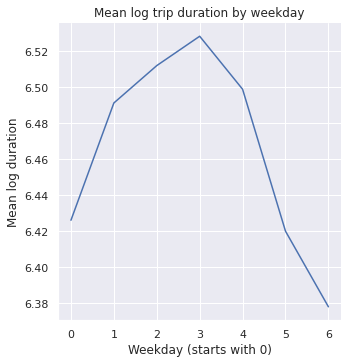

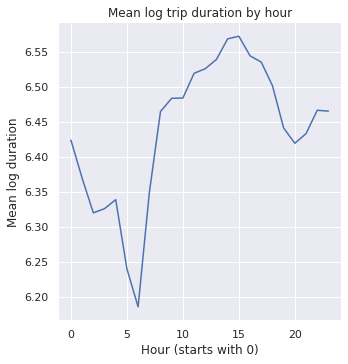

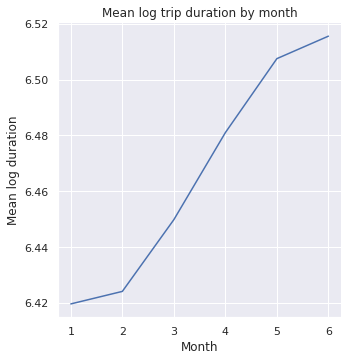

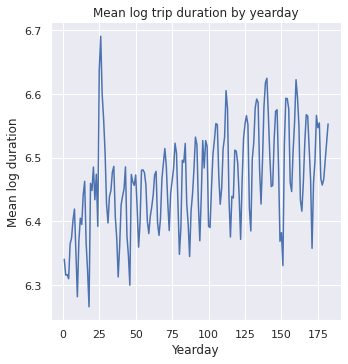

In [24]:
def draw(df, title, x_label, y_label):
  (sns.relplot(x=df.index.get_level_values("param"),
             y="mean_log_trip_duration",
             data=df,
             kind='line',
             palette="gnuplot")
  .set_axis_labels(x_label, y_label))

  plt.title(title)
  plt.show()

draw(mean_by_weekday, "Mean log trip duration by weekday", "Weekday (starts with 0)", "Mean log duration")
draw(mean_by_hour, "Mean log trip duration by hour", "Hour (starts with 0)", "Mean log duration")
draw(mean_by_month, "Mean log trip duration by month", "Month", "Mean log duration")
draw(mean_by_yearday, "Mean log trip duration by yearday", "Yearday", "Mean log duration")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Первые два очень похожи, так как чем больше машин, тем больше пробок => дольше поездка. На третьем графике виден небольшой восходящий тренд, мб это связано с тем, что становится тепелее к середине года и люди перемещаются куда-то за город. Также на 3 графике видна цикличность, которая связана с днями недели, скорее всего. 

В первый аномальный период у нас время очень большое, так как из-за бури долго стояли в пробках. А во второй мало, так как все были на матче.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [25]:
from pandas.core.aggregation import reconstruct_func
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_save : list = [], display=False):
      self.columns_to_save = columns_to_save
      self.display = display
                
    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
      new_features = pd.DataFrame()

      new_features["pickup_weekday"] = X["pickup_datetime"].dt.weekday
      new_features["pickup_month"] = X["pickup_datetime"].dt.month
      new_features["pickup_hour"] = X["pickup_datetime"].dt.hour
      new_features["pickup_yearday"] = X["pickup_datetime"].dt.dayofyear
      new_features["is_anomaly"] = np.nan

      new_features.loc[((new_features["pickup_yearday"] >= 23) & (new_features["pickup_yearday"] <= 25)), "is_anomaly"] = 1
      new_features.loc[(new_features["pickup_yearday"] == 150), "is_anomaly"] = 2
      new_features["is_anomaly"].fillna(0, inplace=True)

      new_features[self.columns_to_save] = X[self.columns_to_save]

      if self.display: display(new_features)

      return new_features

      
          

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

Категориальные: аномалия, час, день недели. Потому что там нет видимой линейной (или похожей на нее) зависимости с таргетом, поэтому лучше сделать категории, так модель сможет лучше понять, что к чему.

Численные: месяц, номер дня в году. Потому что есть возрастающий тренд на графике Mean log trip duration by yearday (видно, что чем больше номер дня в году, тем дольше средний логарифм поездки с поправкой на колебания из-за дня недели) ну и к тому же, было бы очень затратно делать 180 признаков еще. Месяц численный потому что зависимость на графике Mean log trip duration by month похожа на линейную.

Короче говоря, по логике то, что написано выше правдиво, но категориальные признаки работают лучше, потому что тренды не строго линейные, поэтому дальше будем категориальные бахать



**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, data["log_trip_duration"], test_size=0.3)
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday"]
numeric = []

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ("data_transformer", DateTransformer()),
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7891


Сразу добавим к X_train, X_test новые столбцы, чтобы потом не париться с этим

In [28]:
dt = DateTransformer()

data = data.join(dt.transform(data))

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [29]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [30]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [31]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

Выделяются два аэропорта

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [32]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

data.loc[:, 'haversine'] = haversine_array(data['pickup_latitude'].values, data['pickup_longitude'].values,\
                                           data['dropoff_latitude'].values, data['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [33]:
data["haversine_log"] = np.log1p(data["haversine"])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

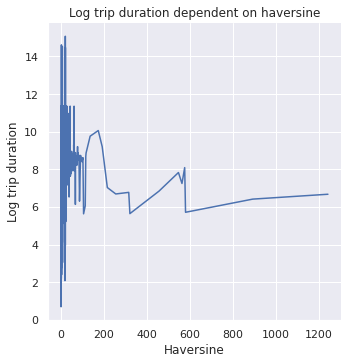

In [34]:
(sns.relplot(x="haversine",
             y='log_trip_duration',
             data=data,
             kind='line',
             palette="gnuplot")
 .set_axis_labels('Haversine', 'Log trip duration'))

plt.title("Log trip duration dependent on haversine")
plt.show()

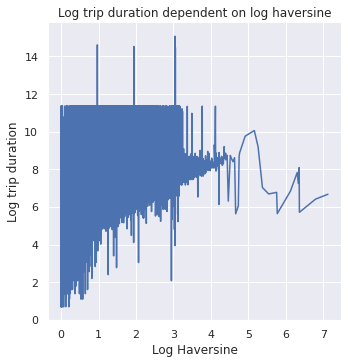

In [35]:
(sns.relplot(x="haversine_log",
             y='log_trip_duration',
             data=data,
             kind='line',
             palette="gnuplot")
 .set_axis_labels('Log Haversine', 'Log trip duration'))

plt.title("Log trip duration dependent on log haversine")
plt.show()

In [36]:
print("Corr between log trip dur and haversine: ", data["log_trip_duration"].corr(data["haversine"]))
print("Corr between log trip dur and log haversine: ", data["log_trip_duration"].corr(data["haversine_log"]))

Corr between log trip dur and haversine:  0.5735948311180146
Corr between log trip dur and log haversine:  0.7498822373942495


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [37]:
data["mean_speed"] = data["haversine"] * 3600 / data["trip_duration"]

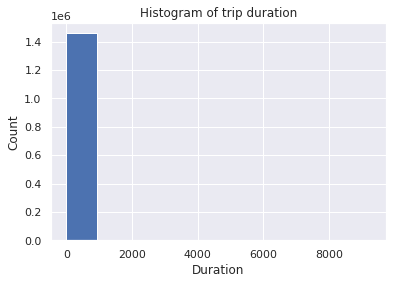

In [38]:
# the histogram of the data
n, bins, patches = plt.hist(data["mean_speed"].values)


plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of trip duration')
plt.grid(True)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [39]:
quantile_999 = data["mean_speed"].quantile(q=0.999)

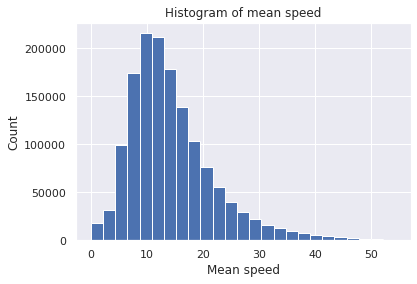

In [40]:
# the histogram of the data
n, bins, patches = plt.hist(data[data["mean_speed"] < quantile_999]["mean_speed"], bins=25)


plt.xlabel('Mean speed')
plt.ylabel('Count')
plt.title('Histogram of mean speed')
plt.grid(True)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [41]:
by_hour_and_day = pd.DataFrame(data.groupby([(data['pickup_datetime'].dt.hour), (data['pickup_datetime'].dt.weekday)]).median().mean_speed)
by_hour_and_day.index.names = ["hour", "day"]
by_hour_and_day.rename(columns={"mean_speed" : "median_speed"}, inplace=True)

In [42]:
df2 = by_hour_and_day.reset_index().pivot(columns='hour',index='day',values='median_speed')

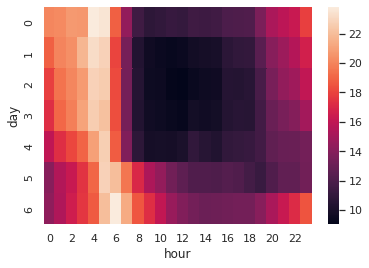

In [43]:
sns.heatmap(df2)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что в расчете скорости фигурирует время -- фактически наш таргет, поэтому мы не можем его рассчитать до того, как узнаем время поездки.

In [44]:
data.drop("mean_speed", axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Минимальна в будние дни днем, максимальна с утра по будням и в выходные (4-7 утра)

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [45]:
data["is_traffic_jam"] = np.NaN
data.loc[(data["pickup_datetime"].dt.weekday <= 4) & \
         ((7 <= data["pickup_datetime"].dt.hour) & (data["pickup_datetime"].dt.hour<= 19)) , "is_traffic_jam"] = 1
data["is_traffic_jam"].fillna(value=0, inplace=True)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [46]:
data["is_dropoff_in_kennedy"] = 0
data["is_dropoff_in_laguardia"] = 0
data["is_pickup_in_kennedy"] = 0
data["is_pickup_in_laguardia"] = 0

laguardia_longitude = -73.873173
laguardia_latitude = 40.772027

kennedy_longitude = -73.781970
kennedy_latitude = 40.643904

In [47]:
data.loc[haversine_array(data["dropoff_latitude"], data["dropoff_longitude"],\
                         kennedy_latitude, kennedy_longitude) < 1.5, "is_dropoff_in_kennedy"] = 1 # 1.5 km radius

data.loc[haversine_array(data["dropoff_latitude"], data["dropoff_longitude"],\
                         laguardia_latitude, laguardia_longitude) < 1.5, "is_dropoff_in_laguardia"] = 1 # 1.5 km radius

data.loc[haversine_array(data["pickup_latitude"], data["pickup_longitude"],\
                         kennedy_latitude, kennedy_longitude) < 1.5, "is_pickup_in_kennedy"] = 1 # 1.5 km radius

data.loc[haversine_array(data["pickup_latitude"], data["pickup_longitude"],\
                         laguardia_latitude, laguardia_longitude) < 1.5, "is_pickup_in_laguardia"] = 1 # 1.5 km radius

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

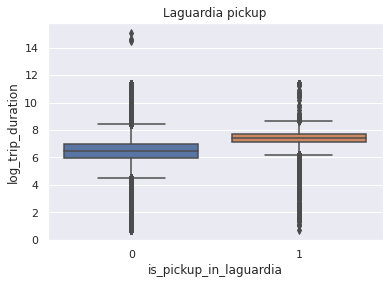

In [48]:
sns.boxplot(data=data, x="is_pickup_in_laguardia", y="log_trip_duration").set_title("Laguardia pickup")
plt.show()

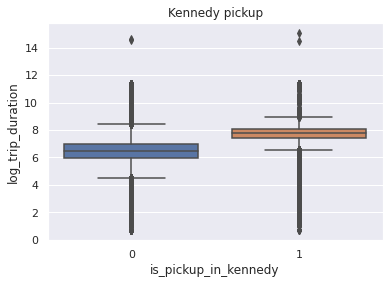

In [49]:
sns.boxplot(data=data, x="is_pickup_in_kennedy", y="log_trip_duration").set_title("Kennedy pickup")
plt.show()

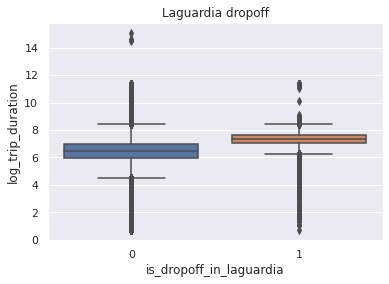

In [50]:
sns.boxplot(data=data, x="is_dropoff_in_laguardia", y="log_trip_duration").set_title("Laguardia dropoff")
plt.show()

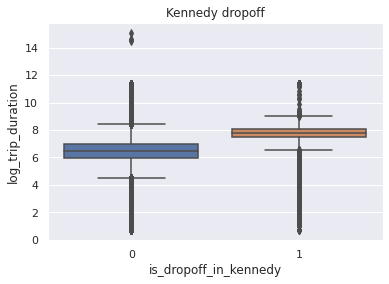

In [51]:
sns.boxplot(data=data, x="is_dropoff_in_kennedy", y="log_trip_duration").set_title("Kennedy dropoff")
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Похоже, что да потому что распределения получились довольно различимыми: медиана у 1 выше чем у 0 в случае всех признаков, максимумы, похоже, что тоже. Так что вроде бы ничего.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [52]:
from pandas.core.aggregation import reconstruct_func
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

from dataclasses import dataclass
@dataclass
class Cell:
    lu_longitude : float
    lu_latitude : float
    rd_longitude : float
    rd_latitude : float
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lu_latitude, lu_longitude, rd_latitude, rd_longitude,
                 rows=4, cols=3, show=False):
        self.cells = []
        self.lu_latitude = lu_latitude
        self.lu_longitude = lu_longitude
        self.rd_latitude = rd_latitude
        self.rd_longitude = rd_longitude
        self.big_rectangle = Cell(lu_longitude, lu_latitude, rd_longitude, rd_latitude)
        self.rows = rows
        self.cols = cols
        self.longitude_step = (rd_longitude - lu_longitude) / self.cols
        self.latitude_step = (rd_latitude - lu_latitude) / self.rows
        for j in range(rows):
          for i in range(cols):
            lu_cell_longitude = self.longitude_step * (i) + lu_longitude
            lu_cell_latitude = self.latitude_step * (j) + lu_latitude

            rd_cell_longitude = lu_cell_longitude + self.longitude_step
            rd_cell_latitude = lu_cell_latitude + self.latitude_step

            self.cells.append(Cell(lu_cell_longitude,
                                   lu_cell_latitude,
                                   rd_cell_longitude,
                                   rd_cell_latitude))
            
            self.mapObj = folium.Map(location=[self.big_rectangle.lu_latitude, self.big_rectangle.lu_longitude],
                  zoom_start=10)
            self.show = show
    
    def show_map(self, X=None):
      folium.Rectangle([(self.big_rectangle.lu_latitude, self.big_rectangle.lu_longitude),
                        (self.big_rectangle.rd_latitude, self.big_rectangle.rd_longitude)], color="red").add_to(self.mapObj)
      for cell in self.cells:
        folium.Rectangle([(cell.lu_latitude, cell.lu_longitude),
                          (cell.rd_latitude, cell.rd_longitude)], color="blue").add_to(self.mapObj)

      
      if X is None: return

      colors = ["red", "blue", "green", "purple", "orange", "darkred", "lightred",\
                "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "pink",\
                "lightblue", "lightgreen", "black"]

      sample = X.sample(1000)
      #display(sample)
      for _, row in sample.iterrows():
        folium.Circle(
            radius=100,
            location=(row["dropoff_latitude"], row["dropoff_longitude"]),
            color=colors[int(row["dropoff_cell"])],
            fill_color=colors[int(row["dropoff_cell"])],
            fill=True
        ).add_to(self.mapObj)

      return self.mapObj

        
    
    def fit(self, X=None, y=None):
        # your code here
        return self

    @staticmethod
    def _is_in_cell(lat, long, cell):
      if cell.lu_latitude <= lat <= cell.rd_latitude and cell.lu_longitude <= long <= cell.rd_longitude:
        return True
      return False 

    def transform(self, X, y=None):
      new_features = pd.DataFrame(index=X.index)
      new_features["pickup_cell"] = -1
      new_features["dropoff_cell"] = -1
      cell_num = 0
      for cell in self.cells:
        max_cell_lat = max(cell.lu_latitude, cell.rd_latitude)
        min_cell_lat = min(cell.lu_latitude, cell.rd_latitude)

        max_cell_lon = max(cell.lu_longitude, cell.rd_longitude)
        min_cell_lon = min(cell.lu_longitude, cell.rd_longitude)


        idxs_pickup = X[(min_cell_lat <= X["pickup_latitude"]) & (X["pickup_latitude"] <= max_cell_lat) & \
                        (min_cell_lon <= X["pickup_longitude"]) & (X["pickup_longitude"] <= max_cell_lon)].index
        
        idxs_dropoff = X[(min_cell_lat <= X["dropoff_latitude"]) & (X["dropoff_latitude"] <= max_cell_lat) & \
                        (min_cell_lon <= X["dropoff_longitude"]) & (X["dropoff_longitude"] <= max_cell_lon)].index

        new_features.loc[idxs_pickup, "pickup_cell"] = cell_num
        new_features.loc[idxs_dropoff, "dropoff_cell"] = cell_num
        cell_num += 1

      if self.show:
        display(self.show_map(X.join(new_features)))

      return new_features
          

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [53]:
mt = MapGridTransformer(40.798800, -74.034736, 40.699576, -73.941160, 4, 3, show=True)
data = data.join(mt.transform(data))

In [54]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]
X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric], data["log_trip_duration"], test_size=0.3)

In [55]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4714


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

vendor_id -- потому что разные провайдеры могут возить в разные места и от этого может зависеть время поездки.

passenger_count -- потому что компании из большого количества людей могут ехать дальше.

store_and_fwd_flag -- потому что у машины могло не быть соединения с сервером, так как она далеко заехала => поездка была долгая

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [56]:
print("vendor_id unique values amount: ", len(data["vendor_id"].unique()))
print("passenger_count unique values amount: ", len(data["passenger_count"].unique()))
print("store_and_fwd_flag unique values amount: ", len(data["store_and_fwd_flag"].unique()))

vendor_id unique values amount:  2
passenger_count unique values amount:  10
store_and_fwd_flag unique values amount:  2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

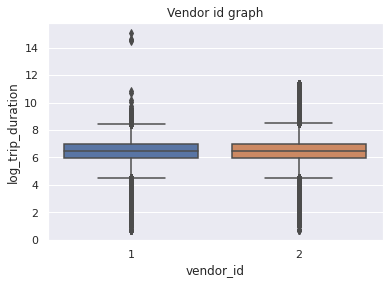

In [57]:
sns.boxplot(data=data, x="vendor_id", y="log_trip_duration").set_title("Vendor id graph")
plt.show()

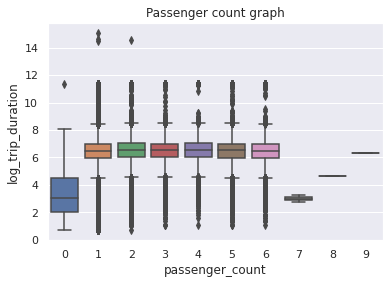

In [58]:
sns.boxplot(data=data, x="passenger_count", y="log_trip_duration").set_title("Passenger count graph")
plt.show()

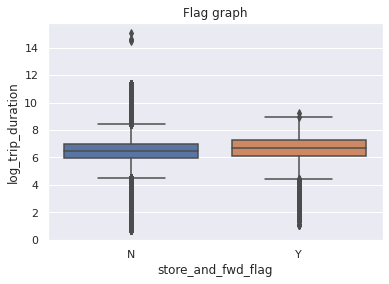

In [59]:
sns.boxplot(data=data, x="store_and_fwd_flag", y="log_trip_duration").set_title("Flag graph")
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [60]:
vendor_id_replace_dict = {1 : 0, 2 : 1}
store_and_fwd_flag_replace_dict = {"N" : 0, "Y" : 1}
data.replace({"vendor_id": vendor_id_replace_dict},inplace=True)
data.replace({"store_and_fwd_flag": store_and_fwd_flag_replace_dict},inplace=True)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Ну распределение сильно отличается только в случае 0 пассажирова, все остальные количества пассажиров не дают значимых отличий в распределении. Так же и с остальными признаками. 

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [61]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam", "store_and_fwd_flag", "vendor_id"]
numeric = ["haversine_log", "passenger_count"]

X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric], data["log_trip_duration"], test_size=0.3)

In [62]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4720


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных. 

In [63]:
data.drop("vendor_id", axis=1, inplace=True)
data.drop("passenger_count", axis=1, inplace=True)
data.drop("store_and_fwd_flag", axis=1, inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

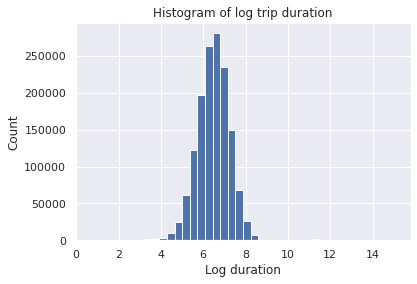

In [64]:
# the histogram of the data
n, bins, patches = plt.hist(data["log_trip_duration"], bins=40)


plt.xlabel('Log duration')
plt.ylabel('Count')
plt.title('Histogram of log trip duration')
plt.grid(True)
plt.show()

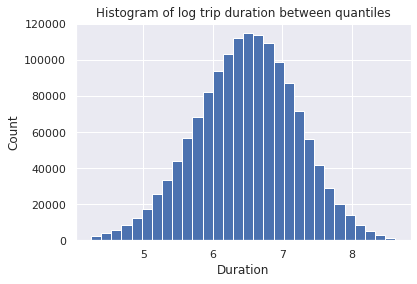

In [65]:
quantile_1 = data["log_trip_duration"].quantile(q=0.998)
quantile_2 = data["log_trip_duration"].quantile(q=0.007)
# the histogram of the data
n, bins, patches = plt.hist(data[(data["log_trip_duration"] <= quantile_1)\
                                 & ((data["log_trip_duration"] >= quantile_2))]["log_trip_duration"], bins=30)


plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of log trip duration between quantiles')
plt.grid(True)
plt.show()

In [66]:
def drop_by_trip_duration(X, quantile_1, quantile_2):
  return X[(X["log_trip_duration"] <= quantile_1)\
                                 & ((X["log_trip_duration"] >= quantile_2))]

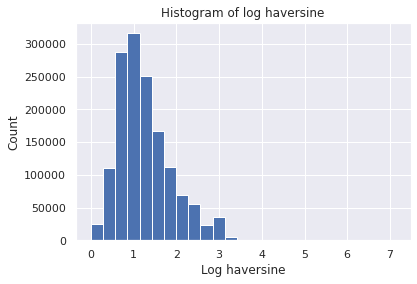

In [67]:
# the histogram of the data
n, bins, patches = plt.hist(data["haversine_log"], bins=25)


plt.xlabel('Log haversine')
plt.ylabel('Count')
plt.title('Histogram of log haversine')
plt.grid(True)
plt.show()

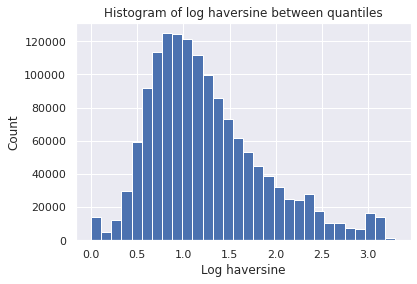

In [68]:
quantile_1 = data["haversine_log"].quantile(q=0.9992)
quantile_2 = data["haversine_log"].quantile(q=0.0001)
# the histogram of the data
n, bins, patches = plt.hist(data[(data["haversine_log"] <= quantile_1)\
                                 & ((data["haversine_log"] >= quantile_2))]["haversine_log"], bins=30)


plt.xlabel('Log haversine')
plt.ylabel('Count')
plt.title('Histogram of log haversine between quantiles')
plt.grid(True)
plt.show()

In [69]:
def drop_by_haversine(X, quantile_1, quantile_2):
  return X[(X["haversine_log"] <= quantile_1)\
                                  & ((X["haversine_log"] >= quantile_2))]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [70]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]

Будем теперь смотреть какие категории объединять в одну в каждом признаке. При этом очевидно, что на бинарные признаки можно забить, там все и так норм.

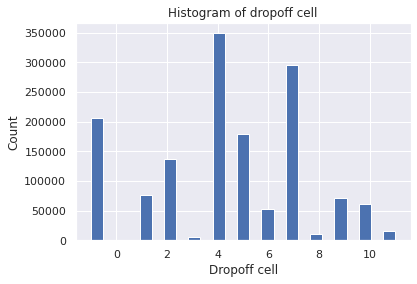

In [71]:
# the histogram of the data
n, bins, patches = plt.hist(data["dropoff_cell"], bins=25)


plt.xlabel('Dropoff cell')
plt.ylabel('Count')
plt.title('Histogram of dropoff cell')
plt.grid(True)
plt.show()

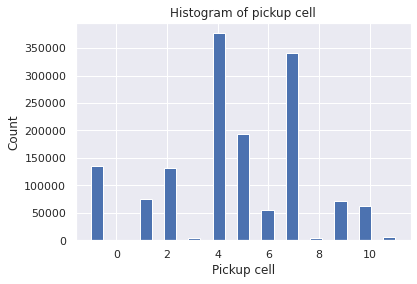

In [72]:
# the histogram of the data
n, bins, patches = plt.hist(data["pickup_cell"], bins=25)


plt.xlabel('Pickup cell')
plt.ylabel('Count')
plt.title('Histogram of pickup cell')
plt.grid(True)
plt.show()

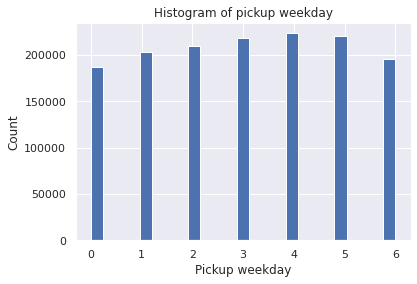

In [73]:
# the histogram of the data
n, bins, patches = plt.hist(data["pickup_weekday"], bins=25)


plt.xlabel('Pickup weekday')
plt.ylabel('Count')
plt.title('Histogram of pickup weekday')
plt.grid(True)
plt.show()

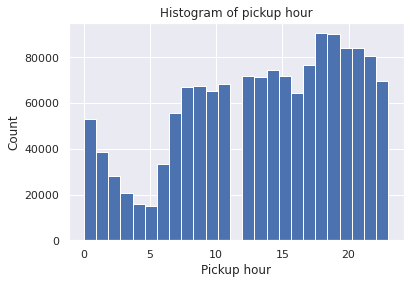

In [74]:
# the histogram of the data
n, bins, patches = plt.hist(data["pickup_hour"], bins=25)


plt.xlabel('Pickup hour')
plt.ylabel('Count')
plt.title('Histogram of pickup hour')
plt.grid(True)
plt.show()

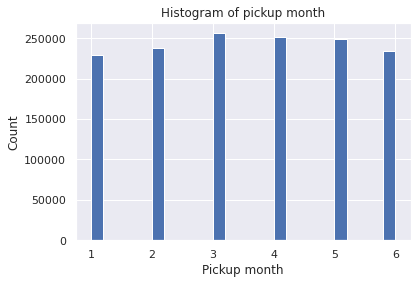

In [75]:
# the histogram of the data
n, bins, patches = plt.hist(data["pickup_month"], bins=25)


plt.xlabel('Pickup month')
plt.ylabel('Count')
plt.title('Histogram of pickup month')
plt.grid(True)
plt.show()

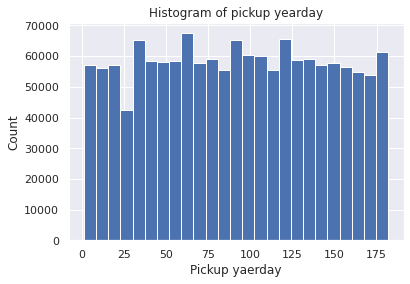

In [76]:
# the histogram of the data
n, bins, patches = plt.hist(data["pickup_yearday"], bins=25)


plt.xlabel('Pickup yaerday')
plt.ylabel('Count')
plt.title('Histogram of pickup yearday')
plt.grid(True)
plt.show()

Видно, что только с номером сектора высадки/подбора какие-то проблемы, поэтому будем объединять их в одну категорию.
[0, 3, 8, 11] -> [-2]. Для этого напишем еще один трансформер, который будет в самом конце объединять в категории.

In [77]:
class UnionRareTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_save : list = [], display=False):
      self.columns_to_save = columns_to_save
      self.display = display
                
    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
      replace_dict = {0: -2, 3 : -2, 8 : -2, 11 : -2}
      

      return X.replace({"dropoff_cell": replace_dict, "pickup_cell" : replace_dict})

In [78]:
ut = UnionRareTransformer()
data = ut.transform(data)

In [79]:
def filter_train(X_train, y_train):

  quantile_1 = X_train["log_trip_duration"].quantile(q=0.998)
  quantile_2 = X_train["log_trip_duration"].quantile(q=0.007)
  X_train = drop_by_trip_duration(X_train, quantile_1, quantile_2)

  quantile_1 = X_train["haversine_log"].quantile(q=0.9992)
  quantile_2 = X_train["haversine_log"].quantile(q=0.0001)
  X_train = drop_by_haversine(X_train, quantile_1, quantile_2)

  X_train.drop("log_trip_duration", axis=1, inplace=True)
  y_train = y_train.loc[X_train.index]

  return X_train, y_train

In [80]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]

X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)

In [81]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4725


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [82]:
print(f"Before OHE: {len(categorical + numeric)}")

Before OHE: 13


In [83]:
print(f"After OHE: {column_transformer.transform(data[categorical + numeric]).shape[1]}")

After OHE: 253


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [84]:
from sklearn.linear_model import Lasso

categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]

X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_lasso = Pipeline(steps=[
    ("ohe_and_scaling", column_transformer),
    ('regression', Lasso())
])

model = pipeline_lasso.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7967


Лучше Ridge

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [85]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]


X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)
X_train = column_transformer.transform(X_train)

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

alphas = np.logspace(-7, 2, 15)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error",\
                        cv=PredefinedSplit(test_fold=[-1] * (len(X_train.toarray()) // 5) + [0] * (len(X_train.toarray()) - (len(X_train.toarray()) // 5)))) # это разобьет нам трейн 8:2, порядок не важен, так как уже все перемешано
searcher.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Ridge(),
             param_grid=[{'alpha': array([1.00000000e-07, 4.39397056e-07, 1.93069773e-06, 8.48342898e-06,
       3.72759372e-05, 1.63789371e-04, 7.19685673e-04, 3.16227766e-03,
       1.38949549e-02, 6.10540230e-02, 2.68269580e-01, 1.17876863e+00,
       5.17947468e+00, 2.27584593e+01, 1.00000000e+02])}],
             scoring='neg_root_mean_squared_error')

Best alpha = 22.7585


Text(0, 0.5, 'score')

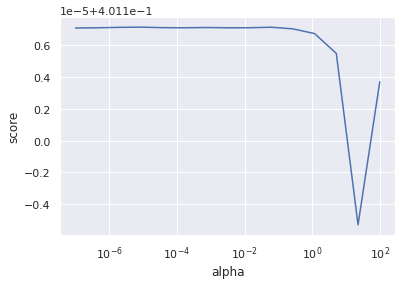

In [87]:
best_alpha_for_ridge = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_for_ridge)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("score")

In [88]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]


X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_ridge = Pipeline(steps=[
    ("ohe_and_scaling", column_transformer),
    ('regression', Ridge(alpha=best_alpha_for_ridge))
])

model = pipeline_ridge.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Ошибка на оптималном alpha для Ridge")
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False)) # с лучшим параметром по сетке

Ошибка на оптималном alpha для Ridge
Test RMSE = 0.4725


Теперь все то же самое но для Lasso

In [89]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]


X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)
X_train = column_transformer.transform(X_train)

In [90]:
alphas = np.logspace(-2, 0.5, 30) # тут взял так мало потому что при больших не сходится, а времени жалко
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error",\
                        cv=PredefinedSplit(test_fold=[-1] * (len(X_train.toarray()) // 5) + [0] * (len(X_train.toarray()) - (len(X_train.toarray()) // 5)))) # это разобьет нам трейн 8:2, порядок не важен, так как уже все перемешано
searcher.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Lasso(),
             param_grid=[{'alpha': array([0.01      , 0.0121957 , 0.01487352, 0.01813931, 0.02212216,
       0.02697954, 0.03290345, 0.04012807, 0.04893901, 0.05968457,
       0.07278954, 0.08877197, 0.10826367, 0.13203518, 0.1610262 ,
       0.1963828 , 0.23950266, 0.29209037, 0.35622479, 0.43444123,
       0.52983169, 0.64616708, 0.78804628, 0.96107797, 1.1721023 ,
       1.42946134, 1.74332882, 2.12611233, 2.5929438 , 3.16227766])}],
             scoring='neg_root_mean_squared_error')

Best alpha = 0.0100


Text(0, 0.5, 'score')

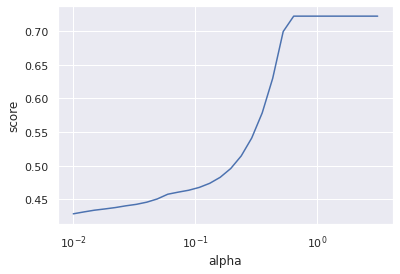

In [91]:
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("score")

In [92]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam"]
numeric = ["haversine_log"]


X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_lasso = Pipeline(steps=[
    ("ohe_and_scaling", column_transformer),
    ('regression', Lasso(alpha=best_alpha))
])

model = pipeline_lasso.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Ошибка на оптималном alpha для Lasso")
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False)) # с лучшим параметром по сетке

Ошибка на оптималном alpha для Lasso
Test RMSE = 0.5050


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [93]:
zeros = []
rmses = []
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
    ])

for alpha in np.logspace(-2, 0.5, 30):
  pipeline_lasso = Pipeline(steps=[
        ("ohe_and_scaling", column_transformer),
        ('regression', Lasso(alpha=alpha))
    ])

  model = pipeline_lasso.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmses.append(mean_squared_error(y_test, y_pred, squared=False))
  zeros.append(len(model["regression"].coef_) - np.count_nonzero(model["regression"].coef_))

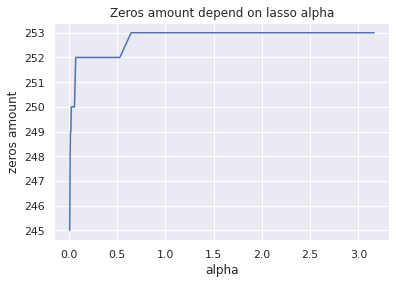

In [94]:
plt.plot(np.logspace(-2, 0.5, 30), zeros)
plt.title("Zeros amount depend on lasso alpha")
plt.xlabel("alpha")
plt.ylabel("zeros amount")
plt.show()

У нас уже Lasso сильно зануляет признаки, как видно, при этом чем меньше альфа, тем лучше результат на евале. Короче говоря, мы не сильно теряем в качестве и зануляем много нулей, при небольших альфа

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [95]:
stat = data.groupby(["pickup_cell", "dropoff_cell"]).count()["is_pickup_in_laguardia"]
stat.rename({"is_pickup_in_laguardia": "count"}, inplace=True)
stat = stat.reset_index()

In [96]:
# тут цикл можно так как фикс. величина количества пар -- 100 штук
data["cells_pairs"] = -1
pair_num = 0
for row in stat.itertuples():
  data[(data["dropoff_cell"] == row.dropoff_cell) &\
                 (data["pickup_cell"] == row.pickup_cell)] = pair_num
  pair_num += 1


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [97]:
categorical = ["pickup_weekday", "pickup_hour", "is_anomaly", "pickup_month", "pickup_yearday", "pickup_cell", "dropoff_cell",
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "is_traffic_jam", "cells_pairs"]
numeric = ["haversine_log"]


X_train, X_test, y_train, y_test = train_test_split(data[categorical + numeric + ["log_trip_duration"]],\
                                                    data["log_trip_duration"], test_size=0.3)
X_train, y_train = filter_train(X_train, y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_ridge = Pipeline(steps=[
    ("ohe_and_scaling", column_transformer),
    ('regression', Ridge(best_alpha_for_ridge))
])

model = pipeline_ridge.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.3234


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [98]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [99]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [100]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.